In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
btc = web.get_data_yahoo('BTC-USD', 
                         start=datetime.datetime(2017, 1, 1),
                        end=datetime.datetime(2017, 12, 27))
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.380005,1001.609985,956.099976,995.440002,995.440002,40570922
2017-01-02,995.440002,1031.680054,990.200012,1017.049988,1017.049988,66038073
2017-01-03,1017.049988,1035.469971,1006.530029,1033.300049,1033.300049,56085870
2017-01-04,1033.300049,1148.540039,1022.320007,1135.410034,1135.410034,170584623
2017-01-05,1135.410034,1150.630005,874.530029,989.349976,989.349976,244839289


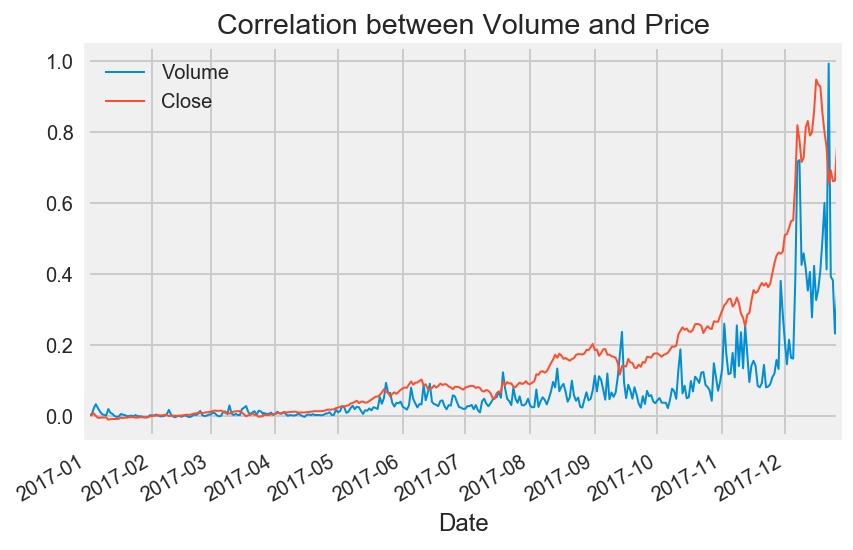

In [32]:
plt.figure()
((btc.Volume-btc.Volume[0])/btc.Volume.max()).plot(lw = 1)
((btc.Close-btc.Close[0])/btc.Close.max()).plot(lw = 1)
plt.title("Correlation between Volume and Price")
plt.legend(loc='upper left')
plt.show()

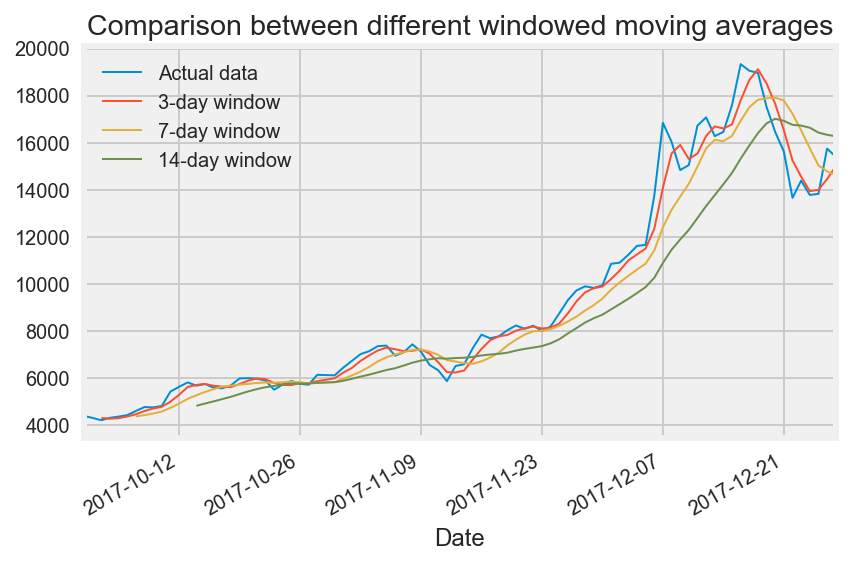

In [45]:
btc_close = btc.Close
btc_recent = btc_close.loc['2017-10-01':'2017-12-27']

MA_3d = btc_recent.rolling(window=3).mean()
MA_7d = btc_recent.rolling(window=7).mean()
MA_14d = btc_recent.rolling(window=14).mean()

plt.figure()
btc_recent.plot(lw = 1, label='Actual data')
MA_3d.plot(lw = 1, label='3-day window')
MA_7d.plot(lw = 1, label='7-day window')
MA_14d.plot(lw = 1, label='14-day window')
plt.legend(loc='upper left')
plt.title('Comparison between different windowed moving averages')
plt.show()